In [1]:
from analytics_utils.describe_data import describe_data
from analytics_utils.interpolate import interpolate
from analytics_utils.correlate import correlate
from statsmodels.tsa.stattools import adfuller
from analytics_utils.roll import roll
from analytics_utils.ewm import ewm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#Perform Dickey-Fuller test:
def dftest(df):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
# Load dataset
# df = pd.read_csv('temp/bear_log.csv', parse_dates={'datetime': ['date', 'time']}, index_col='datetime')
df = pd.read_csv('temp/repsol.csv', parse_dates=['data'], index_col='data')[:200]

In [4]:
# Show the values of bear
display(df)

,ZE-1231181AA,ZE-1231182AA,ZE-1231181BA,ZE-1231182BA,TE-1231197A,TE-1231201A,VE-1231186XA,VE-1231188XA,VE-1231186YA,VE-1231188YA,...,TE-1231198A,TE-1231202A,VE-1231187XA,VE-1231189XA,VE-1231187YA,VE-1231189YA,TE-1231199A,TE-1231203A,TE-1231200A,TE-1231204A
data,,,,,,,,,,,,,,,,,,,,,
2018-06-20 13:53:58,1332.0,NaN,1417.0,NaN,1310.0,NaN,290.0,NaN,523.0,NaN,...,1412.0,NaN,NaN,NaN,900.0,NaN,NaN,NaN,NaN,NaN
2018-06-20 13:54:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-20 13:54:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1214.0,NaN,795.0,...,NaN,NaN,819.0,424.0,NaN,433.0,NaN,NaN,NaN,NaN
2018-06-20 13:54:13,1324.0,1477.0,1412.0,1438.0,NaN,NaN,294.0,NaN,535.0,NaN,...,1392.0,NaN,NaN,NaN,884.0,NaN,NaN,NaN,NaN,NaN
2018-06-20 13:54:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-20 13:54:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1214.0,NaN,NaN,...,NaN,NaN,814.0,425.0,NaN,440.0,NaN,NaN,NaN,NaN
2018-06-20 13:54:28,1319.0,1485.0,1406.0,1446.0,NaN,NaN,299.0,NaN,533.0,NaN,...,1412.0,NaN,NaN,NaN,888.0,NaN,1392.0,1658.0,NaN,NaN
2018-06-20 13:54:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1221.0,NaN,809.0,...,NaN,NaN,829.0,429.0,NaN,429.0,NaN,NaN,NaN,NaN
2018-06-20 13:54:43,1327.0,1488.0,1414.0,1448.0,NaN,NaN,289.0,NaN,538.0,NaN,...,1433.0,NaN,NaN,NaN,875.0,NaN,1412.0,1638.0,NaN,NaN


---

## describe_data

describe_data(
    data_frame: pd.DataFrame, lang: str = "pt", headers: [str] = None
) -> pd.DataFrame

- langs types: {'en', 'pt'}

In [5]:
# Show the datas description
describe_data(df, lang='en')

/opt/anaconda3/envs/analytics-utils/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,max,min,mean,median,1-quartile,3-quartile,variance,standard deviation,absolute deviation,amplitude,rms,kurtosis,skewness,count
header,,,,,,,,,,,,,,
ZE-1231181AA,1350.0,1314.0,1330.469697,1331.5,1323.25,1337.5,79.668298,8.925710,7.576676,36.0,NaN,-0.918955,0.150316,66
ZE-1231182AA,1491.0,1462.0,1481.152542,1482.0,1478.50,1485.5,38.372881,6.194585,4.556737,29.0,NaN,1.900848,-1.137110,59
ZE-1231181BA,1434.0,1402.0,1417.138462,1417.0,1411.00,1423.0,63.433654,7.964525,6.791006,32.0,NaN,-0.961883,0.144052,65
ZE-1231182BA,1452.0,1425.0,1443.724138,1444.0,1441.00,1448.0,34.624319,5.884243,4.185493,27.0,NaN,2.867347,-1.380719,58
TE-1231197A,1330.0,1310.0,1319.743590,1310.0,1310.00,1330.0,102.564103,10.127394,9.993425,20.0,NaN,-2.108108,0.053374,39
TE-1231201A,1330.0,1310.0,1320.000000,1320.0,1310.00,1330.0,109.090909,10.444659,10.000000,20.0,NaN,-2.444444,0.000000,12
VE-1231186XA,313.0,268.0,291.402985,294.0,283.00,301.0,138.850294,11.783475,9.889062,45.0,NaN,-0.854982,-0.386920,67
VE-1231188XA,1233.0,1199.0,1223.265625,1223.0,1220.75,1228.0,40.071181,6.330180,4.680176,34.0,NaN,2.579848,-1.127695,64
VE-1231186YA,576.0,510.0,542.880597,539.0,526.00,561.5,375.864315,19.387220,16.890176,66.0,NaN,-1.245363,0.160456,67


---

## correlate

correlate(
    data_frame: pd.DataFrame, method: str = "pearson", min_periods: int = 1
) -> pd.DataFrame

- methos types: {‘pearson’, ‘kendall’, ‘spearman’}

In [6]:
# Show correlation matrix datas
corr = correlate(df)
display(corr)

,ZE-1231181AA,ZE-1231182AA,ZE-1231181BA,ZE-1231182BA,TE-1231197A,TE-1231201A,VE-1231186XA,VE-1231188XA,VE-1231186YA,VE-1231188YA,...,TE-1231198A,TE-1231202A,VE-1231187XA,VE-1231189XA,VE-1231187YA,VE-1231189YA,TE-1231199A,TE-1231203A,TE-1231200A,TE-1231204A
ZE-1231181AA,1.000000,-0.478221,0.994707,-0.501295,-0.230632,-0.120562,0.012778,NaN,-0.008644,NaN,...,-0.034463,NaN,NaN,NaN,-0.148524,NaN,-0.350881,0.325670,NaN,NaN
ZE-1231182AA,-0.478221,1.000000,-0.466596,0.982462,0.021724,0.020605,-0.222196,NaN,-0.182568,NaN,...,0.005659,NaN,NaN,NaN,-0.084442,NaN,0.597318,-0.654950,NaN,NaN
ZE-1231181BA,0.994707,-0.466596,1.000000,-0.494454,-0.241589,-0.134178,0.000767,NaN,-0.012164,NaN,...,-0.015298,NaN,NaN,NaN,-0.146955,NaN,-0.337409,0.324790,NaN,NaN
ZE-1231182BA,-0.501295,0.982462,-0.494454,1.000000,0.099199,-0.076053,-0.198977,NaN,-0.134677,NaN,...,-0.063265,NaN,NaN,NaN,-0.097172,NaN,0.628202,-0.695052,NaN,NaN
TE-1231197A,-0.230632,0.021724,-0.241589,0.099199,1.000000,-0.550000,-0.073702,NaN,-0.063446,NaN,...,0.147132,NaN,NaN,NaN,-0.080610,NaN,0.229590,-0.537484,NaN,NaN
TE-1231201A,-0.120562,0.020605,-0.134178,-0.076053,-0.550000,1.000000,0.254924,NaN,0.264450,NaN,...,-0.499184,NaN,NaN,NaN,0.212178,NaN,-0.398252,0.327327,NaN,NaN
VE-1231186XA,0.012778,-0.222196,0.000767,-0.198977,-0.073702,0.254924,1.000000,NaN,0.615961,NaN,...,-0.310128,NaN,NaN,NaN,0.746649,NaN,-0.198795,0.363834,NaN,NaN
VE-1231188XA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.532470,...,NaN,NaN,0.069511,-0.139601,NaN,-0.165477,NaN,NaN,NaN,NaN
VE-1231186YA,-0.008644,-0.182568,-0.012164,-0.134677,-0.063446,0.264450,0.615961,NaN,1.000000,NaN,...,-0.107209,NaN,NaN,NaN,0.727921,NaN,-0.403619,0.373563,NaN,NaN
VE-1231188YA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.532470,NaN,1.000000,...,NaN,NaN,0.145705,0.372021,NaN,-0.254534,NaN,NaN,NaN,NaN


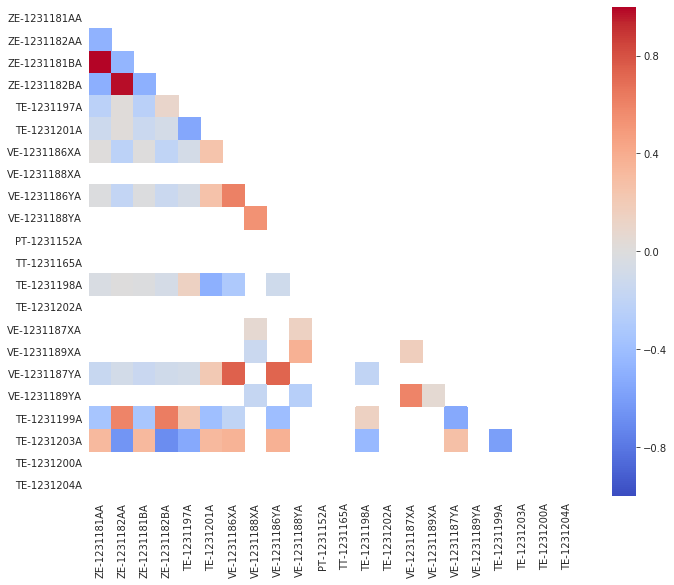

In [7]:
# Show correlation matrix
# sns.heatmap(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.figure(figsize=(12, 9))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', square=True)

---

## interpolate

- Please note that only method='linear' is supported for DataFrame/Series with a MultiIndex.
- methods types: {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’ ‘piecewise_polynomial’, ‘pchip’}

In [8]:
# Show interpolate linear
inter_linear = interpolate(df.iloc[:,0], method="linear")
inter_linear = inter_linear.rename(inter_linear.name+"_linear")
display(inter_linear)

data
2018-06-20 13:53:58    1332.000000
2018-06-20 13:54:04    1329.333333
2018-06-20 13:54:12    1326.666667
2018-06-20 13:54:13    1324.000000
2018-06-20 13:54:19    1322.333333
                          ...     
2018-06-20 14:10:19    1316.000000
2018-06-20 14:10:27    1318.000000
2018-06-20 14:10:28    1320.000000
2018-06-20 14:10:35    1320.000000
2018-06-20 14:10:42    1320.000000
Name: ZE-1231181AA_linear, Length: 200, dtype: float64

In [9]:
# Show interpolate cubic
inter_cubic = interpolate(df.iloc[:,0], method="cubic")
inter_cubic = inter_cubic.rename(inter_cubic.name+"_cubic")
display(inter_cubic)

data
2018-06-20 13:53:58    1332.000000
2018-06-20 13:54:04    1329.575095
2018-06-20 13:54:12    1324.636189
2018-06-20 13:54:13    1324.000000
2018-06-20 13:54:19    1320.646792
                          ...     
2018-06-20 14:10:19    1314.004160
2018-06-20 14:10:27    1318.896304
2018-06-20 14:10:28    1320.000000
2018-06-20 14:10:35            NaN
2018-06-20 14:10:42            NaN
Name: ZE-1231181AA_cubic, Length: 200, dtype: float64

In [10]:
# Show [0] column of time series with cubic and linear interpolate
wide_df = df.iloc[:,0].copy()
wide_df = pd.concat([wide_df, inter_linear, inter_cubic], axis=1)
display(wide_df)

,ZE-1231181AA,ZE-1231181AA_linear,ZE-1231181AA_cubic
data,,,
2018-06-20 13:53:58,1332.0,1332.000000,1332.000000
2018-06-20 13:54:04,NaN,1329.333333,1329.575095
2018-06-20 13:54:12,NaN,1326.666667,1324.636189
2018-06-20 13:54:13,1324.0,1324.000000,1324.000000
2018-06-20 13:54:19,NaN,1322.333333,1320.646792
2018-06-20 13:54:27,NaN,1320.666667,1318.884407
2018-06-20 13:54:28,1319.0,1319.000000,1319.000000
2018-06-20 13:54:42,NaN,1323.000000,1326.396553
2018-06-20 13:54:43,1327.0,1327.000000,1327.000000


/opt/anaconda3/envs/analytics-utils/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


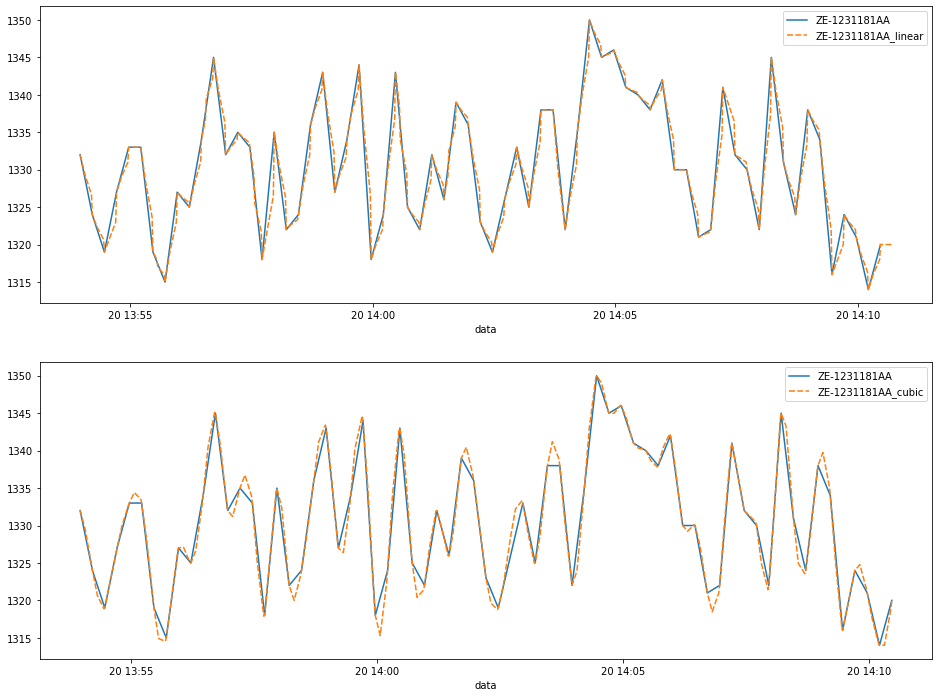

In [11]:
# Show plot [0] column of time series with cubic and linear interpolate
zero_df = df.iloc[:,0].copy()
linear_df = pd.concat([zero_df, inter_linear], axis=1)
cubic_df = pd.concat([zero_df, inter_cubic], axis=1)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.lineplot(data=linear_df, ax=ax1)
sns.lineplot(data=cubic_df, ax=ax2)

---

## roll (rolling window)

def roll(
    data_frame: pd.DataFrame,
    window: int,
    roll_type: str = "mean",
    headers: [str] = None,
) -> pd.DataFrame

- roll_type: {‘mean’, ‘var’, 'std'}

In [12]:
# Show moving average, std and var in the column zero
roll_df = cubic_df.iloc[:,1].copy()
m_roll = roll(roll_df, 24, roll_type="mean")
m_roll = m_roll.rename(m_roll.name+"_mean")
std_roll = roll(roll_df, 24, roll_type="std")
std_roll = std_roll.rename(std_roll.name+"_std")
var_roll = roll(roll_df, 24, roll_type="var")
var_roll = var_roll.rename(var_roll.name+"_var")
wide_rdf = pd.concat([roll_df, m_roll, std_roll, var_roll], axis=1)
display(wide_rdf)

,ZE-1231181AA_cubic,ZE-1231181AA_cubic_mean,ZE-1231181AA_cubic_std,ZE-1231181AA_cubic_var
data,,,,
2018-06-20 13:53:58,1332.000000,NaN,NaN,NaN
2018-06-20 13:54:04,1329.575095,NaN,NaN,NaN
2018-06-20 13:54:12,1324.636189,NaN,NaN,NaN
2018-06-20 13:54:13,1324.000000,NaN,NaN,NaN
2018-06-20 13:54:19,1320.646792,NaN,NaN,NaN
2018-06-20 13:54:27,1318.884407,NaN,NaN,NaN
2018-06-20 13:54:28,1319.000000,NaN,NaN,NaN
2018-06-20 13:54:42,1326.396553,NaN,NaN,NaN
2018-06-20 13:54:43,1327.000000,NaN,NaN,NaN


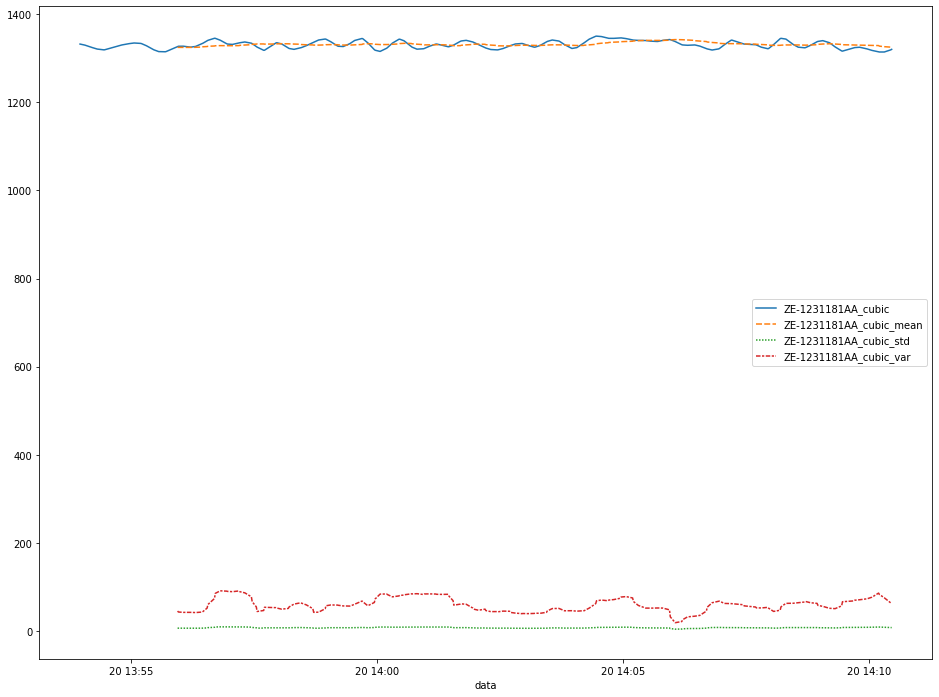

In [13]:
# Show graphic moving average, std and var in the column zero
fig = plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=wide_rdf)

In [14]:
# Show Dickey-Fuller test (real value - mean value)
dftest((wide_rdf.iloc[:,0] - wide_rdf.iloc[:,1]).dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.528201
p-value                          0.108763
#Lags Used                       6.000000
Number of Observations Used    168.000000
Critical Value (1%)             -3.469886
Critical Value (5%)             -2.878903
Critical Value (10%)            -2.576027
dtype: float64


---

## ewm (exponential weighted moving)

def ewm(
        data_frame: pd.DataFrame,
        com: float = None,
        span: float = None,
        halflife: float = None,
        alpha: float = None,
        ignore_na: bool = False,
        ewm_type: str = "mean",
        headers: [str] = None,
    ) -> pd.DataFrame

- com: α=1/(1+com), for com≥0
- span: α=2/(span+1), for span≥1
- halflife: α=1−exp(log(0.5)/halflife), for halflife>0
- alpha: 0<α≤1
- ewm_types: {‘mean’, ‘var’, 'std'}

In [15]:
# Show ewm average, std and var in the column zero
ewm_df = cubic_df.iloc[:,1].copy()
m_ewm = ewm(ewm_df, halflife=24, ewm_type="mean")
m_ewm = m_ewm.rename(m_ewm.name+"_mean")
std_ewm = ewm(ewm_df, halflife=24, ewm_type="std")
std_ewm = std_ewm.rename(std_ewm.name+"_std")
var_ewm = ewm(ewm_df, halflife=24, ewm_type="var")
var_ewm = var_ewm.rename(var_ewm.name+"_var")
wide_edf = pd.concat([ewm_df, m_ewm, std_ewm, var_ewm], axis=1)
display(wide_edf)

,ZE-1231181AA_cubic,ZE-1231181AA_cubic_mean,ZE-1231181AA_cubic_std,ZE-1231181AA_cubic_var
data,,,,
2018-06-20 13:53:58,1332.000000,1332.000000,NaN,NaN
2018-06-20 13:54:04,1329.575095,1330.770040,1.714667,2.940083
2018-06-20 13:54:12,1324.636189,1328.666096,3.764359,14.170398
2018-06-20 13:54:13,1324.000000,1327.448561,3.861366,14.910149
2018-06-20 13:54:19,1320.646792,1326.008518,4.546980,20.675028
2018-06-20 13:54:27,1318.884407,1324.733816,5.024903,25.249648
2018-06-20 13:54:28,1319.000000,1323.842051,5.076634,25.772216
2018-06-20 13:54:42,1326.396553,1324.194557,4.759369,22.651593
2018-06-20 13:54:43,1327.000000,1324.543475,4.526671,20.490749


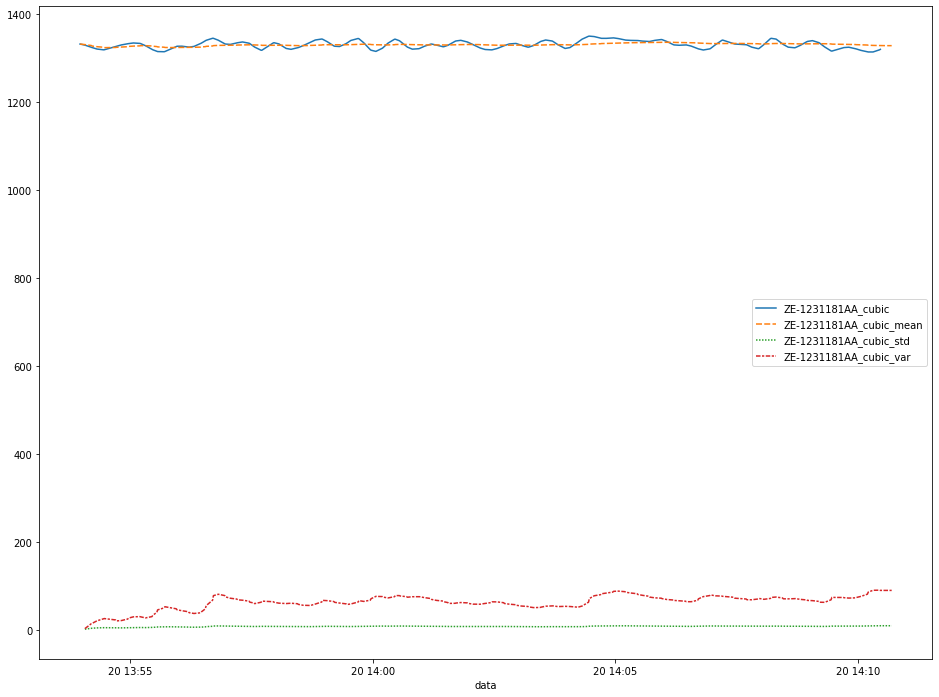

In [16]:
# Show graphic ewm average, std and var in the column zero
fig = plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=wide_edf)

In [18]:
# Show Dickey-Fuller test (real value - mean value)
dftest((wide_edf.iloc[:,0] - wide_edf.iloc[:,1]).dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.657985
p-value                          0.081595
#Lags Used                       6.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64
